# Training a model with a curated image dataset in fastai with dataset augmentation
Walkthrough of how to train a deep learning model in fastai with a curated image dataset incorporating an augmented dataset


In [1]:
# imports for notebook boilerplate
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.all import *
modifier = 'jun9_2021'

In [2]:
# set up the notebook for fast.ai
fastbook.setup_book()

# Ingest the dataset
- create a path object
- defined an ImageDataLoaders object

In [3]:
# ingest the curated image dataset CIFAR
path = untar_data(URLs.CIFAR)

In [4]:
path

Path('/storage/data/cifar10')

In [5]:
# examine the directory structure of the dataset
path.ls()

(#3) [Path('/storage/data/cifar10/train'),Path('/storage/data/cifar10/labels.txt'),Path('/storage/data/cifar10/test')]

In [6]:
# define a DataBlock object
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label)

In [7]:
dls = db.dataloaders(path/'train',bs=32)

In [8]:
# summary must be run on DataBlock object, not dataloaders object
db.summary(path/"train")

Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying parent_label gives
      truck
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(9))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the firs

# Examine the dataset

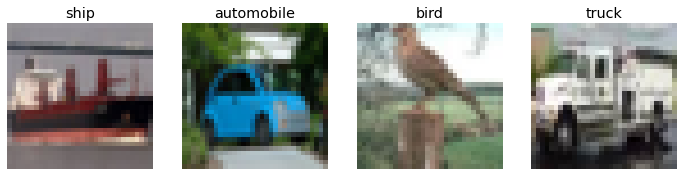

In [9]:
# show a batch of training data
dls.train.show_batch(max_n=4, nrows=1)


In [10]:
# examine the train subdirectory
(path/'train').ls()

(#10) [Path('/storage/data/cifar10/train/horse'),Path('/storage/data/cifar10/train/dog'),Path('/storage/data/cifar10/train/ship'),Path('/storage/data/cifar10/train/frog'),Path('/storage/data/cifar10/train/truck'),Path('/storage/data/cifar10/train/deer'),Path('/storage/data/cifar10/train/airplane'),Path('/storage/data/cifar10/train/automobile'),Path('/storage/data/cifar10/train/cat'),Path('/storage/data/cifar10/train/bird')]

In [11]:
(path/'train/dog').ls()

(#5000) [Path('/storage/data/cifar10/train/dog/26785_dog.png'),Path('/storage/data/cifar10/train/dog/47662_dog.png'),Path('/storage/data/cifar10/train/dog/48730_dog.png'),Path('/storage/data/cifar10/train/dog/40889_dog.png'),Path('/storage/data/cifar10/train/dog/24363_dog.png'),Path('/storage/data/cifar10/train/dog/44046_dog.png'),Path('/storage/data/cifar10/train/dog/26962_dog.png'),Path('/storage/data/cifar10/train/dog/19003_dog.png'),Path('/storage/data/cifar10/train/dog/47416_dog.png'),Path('/storage/data/cifar10/train/dog/31111_dog.png')...]

In [12]:
(path/'train/cat').ls()

(#5000) [Path('/storage/data/cifar10/train/cat/1845_cat.png'),Path('/storage/data/cifar10/train/cat/26087_cat.png'),Path('/storage/data/cifar10/train/cat/24817_cat.png'),Path('/storage/data/cifar10/train/cat/47541_cat.png'),Path('/storage/data/cifar10/train/cat/44852_cat.png'),Path('/storage/data/cifar10/train/cat/37669_cat.png'),Path('/storage/data/cifar10/train/cat/11236_cat.png'),Path('/storage/data/cifar10/train/cat/4329_cat.png'),Path('/storage/data/cifar10/train/cat/44859_cat.png'),Path('/storage/data/cifar10/train/cat/22425_cat.png')...]

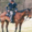

In [13]:
# take a look at one of the images
img_files = get_image_files(path)
img = PILImage.create(img_files[100])
img

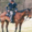

In [14]:
# display a thumbnail of the image
img.to_thumb(180)

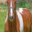

In [15]:
img = PILImage.create(img_files[3000])
img

# Define and train the model

In [16]:
# define the model
learn = cnn_learner(dls, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,1.870966,1.737483,0.448600,01:32


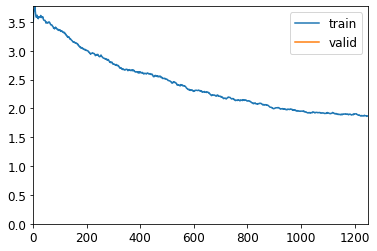

epoch,train_loss,valid_loss,accuracy,time
0,1.248233,1.160732,0.714300,01:49
1,1.109203,1.067518,0.752600,01:48


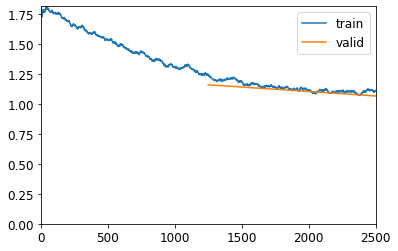

CPU times: user 4min 55s, sys: 5.64 s, total: 5min 1s
Wall time: 5min 10s


In [17]:
%%time
learn.fine_tune(2,cbs=ShowGraphCallback())

In [18]:
learn.summary()

Sequential (Input shape: ['32 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 16 x 16    9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 16 x 16    128        True      
________________________________________________________________
ReLU                 32 x 64 x 16 x 16    0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 8 x 8      0          False     
________________________________________________________________
Conv2d               32 x 64 x 8 x 8      36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 8 x 8      128        True      
________________________________________________________________
ReLU                 32 x 64 x 8 x 8      0          False     
___________________________________________________

In [19]:
# save the model using the trick to specify a writeable directory
save_path = learn.path
learn.path = Path('/notebooks/temp/models')
learn.export('cifar_'+modifier+'.pkl')
learn.save('cifar_save_'+modifier)
learn.path = save_path

# Try augmenting the training set

In [20]:
# create a new DataBlock object incorporating augmentation transformations
db2 = db.new(batch_tfms=aug_transforms())
# create a new dataloaders object based on the new DataBlock object
dls2 = db2.dataloaders(path/'train',bs=32)


In [21]:
db2.summary(path/"train")

Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying parent_label gives
      truck
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(9))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad

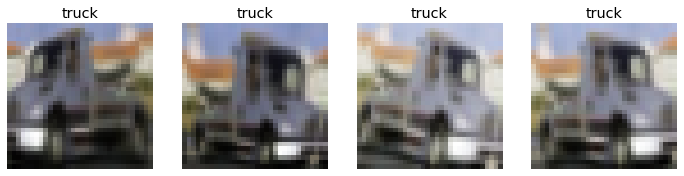

In [22]:
# examine a batch of the augmented training data
dls2.train.show_batch(unique=True,max_n=4, nrows=1)

In [23]:
# define a distinct model based on the augmented dataloaders object
learn2 = cnn_learner(dls2, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

In [24]:
%%time
learn2.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.926180,1.752155,0.442300,01:40


epoch,train_loss,valid_loss,accuracy,time
0,1.356869,1.199771,0.695700,01:57
1,1.197363,1.099920,0.736000,01:57


CPU times: user 5min 22s, sys: 7.2 s, total: 5min 30s
Wall time: 5min 35s


In [25]:
learn2.summary()

Sequential (Input shape: ['32 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 16 x 16    9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 16 x 16    128        True      
________________________________________________________________
ReLU                 32 x 64 x 16 x 16    0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 8 x 8      0          False     
________________________________________________________________
Conv2d               32 x 64 x 8 x 8      36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 8 x 8      128        True      
________________________________________________________________
ReLU                 32 x 64 x 8 x 8      0          False     
___________________________________________________

In [26]:
# save the model using the trick to specify a writeable directory
save_path = learn2.path
learn2.path = Path('/notebooks/temp/models')
learn2.export('cifar_augment_'+modifier+'.pkl')
learn2.save('cifar_save_augment_'+modifier)
learn2.path = save_path

# Examine the performance of the model


In [27]:
# validate the original model
learn.validate()

(#2) [1.0675183534622192,0.7526000142097473]

In [28]:
# validate the model trained with the augmented dataset
learn2.validate()

(#2) [1.0999202728271484,0.7360000014305115]

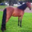

In [29]:
# take a look at one of the test images
img_test_files = get_image_files(path/"test")
img2 = PILImage.create(img_test_files[700])
img2

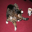

In [30]:
# select an image from the test set
img3 = PILImage.create(img_test_files[8000])
img3

In [31]:
# apply the trained model to the image
learn2.predict(img2)

('horse',
 TensorImage(7),
 TensorImage([0.0062, 0.0167, 0.0084, 0.0162, 0.0174, 0.0258, 0.0089, 0.8810, 0.0075, 0.0119]))

In [32]:
# apply the trained model to the image
learn2.predict(img3)

('dog',
 TensorImage(5),
 TensorImage([0.0226, 0.0124, 0.0250, 0.3091, 0.0155, 0.5387, 0.0342, 0.0284, 0.0034, 0.0107]))

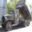

In [33]:
# select an image from the test set
img4 = PILImage.create(img_test_files[4000])
img4

In [34]:
learn2.predict(img4)

('truck',
 TensorImage(9),
 TensorImage([0.0096, 0.0932, 0.0159, 0.0323, 0.0166, 0.0167, 0.0336, 0.0105, 0.0119, 0.7598]))

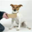

In [35]:
# take a look at a dog image from the training dataset
dog_files = get_image_files(path/"train/dog")
dog_img = PILImage.create(dog_files[30])
dog_img

In [36]:
learn2.predict(dog_img)

('dog',
 TensorImage(5),
 TensorImage([0.0252, 0.0096, 0.0416, 0.3462, 0.0561, 0.4305, 0.0351, 0.0340, 0.0115, 0.0103]))

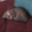

In [37]:
# take a look at a cat image from the training dataset
cat_files = get_image_files(path/"train/cat")
cat_img = PILImage.create(cat_files[30])
cat_img

In [38]:
learn2.predict(cat_img)

('cat',
 TensorImage(3),
 TensorImage([0.0267, 0.0490, 0.0217, 0.2861, 0.0210, 0.1335, 0.0448, 0.2472, 0.0151, 0.1549]))

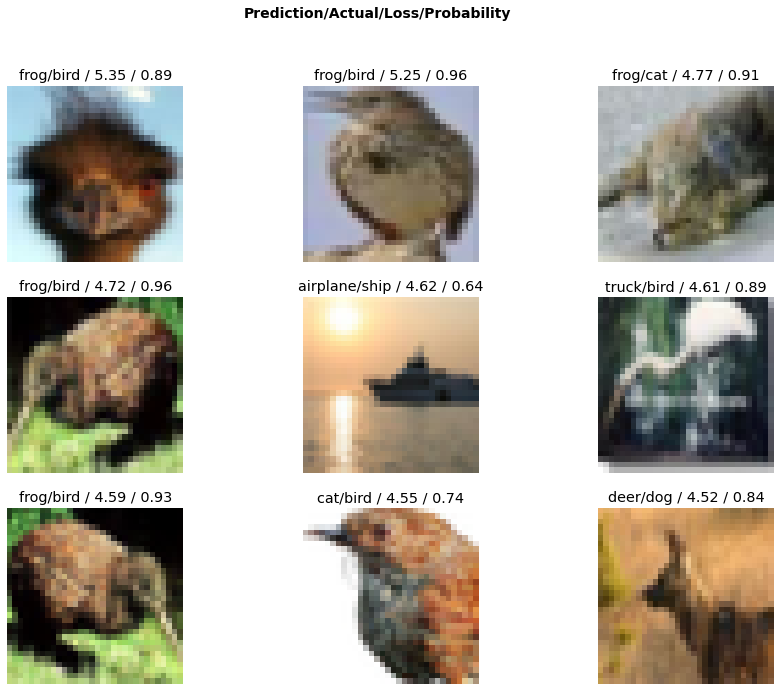

In [39]:
interp = ClassificationInterpretation.from_learner(learn2)
# examine the images from the training set with the biggest loss
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))


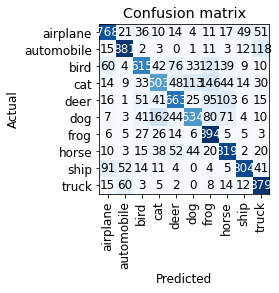

In [40]:
# plot the confusion matrix
interp.plot_confusion_matrix()

# Examine the performance of the model on the test set

In [42]:
# define a dataloader object on the test dataset
dls_test = db.dataloaders(path/'test',bs=32)

In [43]:
# define a model for the augmented model
learn_augment_test = cnn_learner(dls_test, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

In [44]:
# point the model's path to where the weights were saved and load the weights for the model trained with augmented data
learn_augment_test.path = Path('/notebooks/temp/models')
learn_augment_test.load('cifar_save_augment_'+modifier)

In [45]:
learn_augment_test.validate()

(#2) [1.0997446775436401,0.7304999828338623]

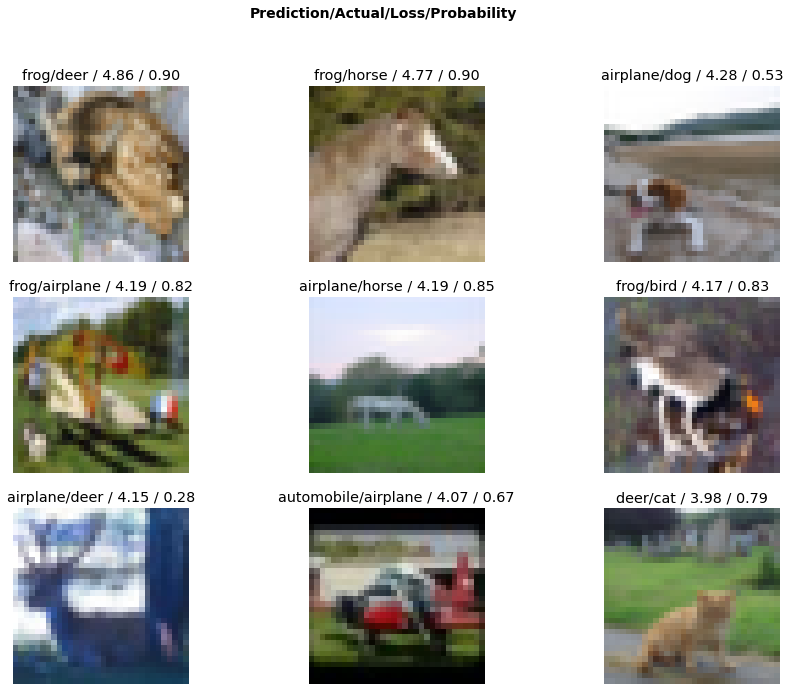

In [47]:
# show confusion matrix for the test dataset
interp_augment_test = ClassificationInterpretation.from_learner(learn_augment_test)
# examine the images from the training set with the biggest loss
losses,idxs = interp_augment_test.top_losses()
interp_augment_test.plot_top_losses(9, figsize=(15,11))


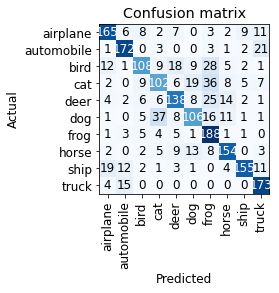

In [48]:
interp_augment_test.plot_confusion_matrix()